<a href="https://colab.research.google.com/github/jakphunn/DADS6003/blob/main/6610412008_Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas
!pip install numpy
!pip install requests
!pip install lxml
!pip install yfinance
!pip install matplotlib
!pip install scikit-learn
!pip install pandas_datareader

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib

--2024-02-19 16:52:45--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-02-19 16:52:45--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-02-19 16:52:45--  http://cytranet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving cytranet.dl.s

In [3]:
# Data Manipulation
import numpy as np
import pandas as pd
import lxml
import requests

# Technical Indicators
import talib as ta

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Data fetching
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
#data frame for the original model.
df = yf.download('AOT.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df = df.dropna()
df = df.iloc[:,:4]

#data frame for my model, I want to keep the volume and adj price.
df2 = yf.download('AOT.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df = df.dropna()
df2 = df2.iloc[:,:6]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
# making indicator columns (X) for the original model;
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]

# indicators columns (X) for my model;
sett = yf.download('^SET.bk', start='2023-06-01', end='2023-12-10', interval = '1h')
df2['set_index'] = sett['Close']
df2['S_5'] = df2['Close'].rolling(window=5).mean()
df2['S_10'] = df2['Close'].rolling(window=10).mean()
df2['Corr'] = df2['Close'].rolling(window=10).corr(df2['S_10'])
df2['RSI'] = ta.RSI(np.array(df2['Close']), timeperiod =10)
df2['Open-Close'] = df2['Open'] - df2['Close'].shift(1)
df2['Open-Open'] = df2['Open'] - df2['Open'].shift(1)
macd, signal, _ = ta.MACD(df2['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
df2['MACD'] = macd
df2['MACD_Signal'] = signal
df2['SAR'] = ta.SAR(df2['High'], df2['Low'], acceleration = 0.02, maximum = 0.2)
df2['Signal'] = np.nan
df2.loc[(df2['Close'] < df2['SAR']), 'Signal'] = -1
df2.loc[(df2['Close'] > df2['SAR']), 'Signal'] = 1
df2 = df2.dropna()
X2 = df2.iloc[:,:]

[*********************100%%**********************]  1 of 1 completed


In [6]:
# making target column (y) for the original model and my model

y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)
y2 = np.where(df2['Close'].shift(-1) > df2['Close'],1,-1)

In [7]:
#split for testing

split = int(0.8*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

split2 = int(0.8*len(df2))
X2_train, X2_test, y2_train, y2_test = X2[:split], X2[split:], y2[:split], y2[split:]

In [8]:
#model training
model = LogisticRegression(max_iter = 1000000000)
model = model.fit (X_train,y_train)

model2 = LogisticRegression(max_iter = 1000000000)
model2 = model2.fit (X2_train,y2_train)

In [9]:
#shows the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))
pd.DataFrame(zip(X2.columns, np.transpose(model2.coef_)))

,0,1
0,Open,[-3.150288600664597e-05]
1,High,[-3.161905787224988e-05]
2,Low,[-3.144764621568346e-05]
3,Close,[-3.1600437651487623e-05]
4,Adj Close,[-3.1600437651487623e-05]
5,Volume,[3.189643868148945e-08]
6,set_index,[-0.0006715226810765232]
7,S_5,[-3.1525105359710106e-05]
8,S_10,[-3.152327294802665e-05]
9,Corr,[-1.0618431773445806e-07]


In [10]:
probability = model.predict_proba(X_test)
probability2 = model2.predict_proba(X2_test)
print (probability)

[[0.66033225 0.33966775]
 [0.68127514 0.31872486]
 [0.73871197 0.26128803]
 [0.70698124 0.29301876]
 [0.72640476 0.27359524]
 [0.57176513 0.42823487]
 [0.59289987 0.40710013]
 [0.61706192 0.38293808]
 [0.71387746 0.28612254]
 [0.79998587 0.20001413]
 [0.69878991 0.30121009]
 [0.77880257 0.22119743]
 [0.70722634 0.29277366]
 [0.60908904 0.39091096]
 [0.76540899 0.23459101]
 [0.7028317  0.2971683 ]
 [0.80758196 0.19241804]
 [0.60160069 0.39839931]
 [0.55104132 0.44895868]
 [0.54683257 0.45316743]
 [0.60276218 0.39723782]
 [0.78880702 0.21119298]
 [0.62695454 0.37304546]
 [0.59428066 0.40571934]
 [0.8400545  0.1599455 ]
 [0.79778167 0.20221833]
 [0.67966393 0.32033607]
 [0.75203151 0.24796849]
 [0.79160307 0.20839693]
 [0.90265522 0.09734478]
 [0.7434385  0.2565615 ]
 [0.74039935 0.25960065]
 [0.57574782 0.42425218]
 [0.85437305 0.14562695]
 [0.65876799 0.34123201]
 [0.64532603 0.35467397]
 [0.6411053  0.3588947 ]
 [0.82996266 0.17003734]
 [0.84389485 0.15610515]
 [0.65113694 0.34886306]


In [11]:
predicted = model.predict(X_test)
predicted2 = model2.predict(X2_test)

In [12]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.confusion_matrix(y2_test, predicted2))

[[93 11]
 [34 14]]
[[92  1]
 [43  1]]


In [13]:
print(metrics.classification_report(y_test, predicted))
print(metrics.classification_report(y2_test, predicted2))

              precision    recall  f1-score   support

          -1       0.73      0.89      0.81       104
           1       0.56      0.29      0.38        48

    accuracy                           0.70       152
   macro avg       0.65      0.59      0.59       152
weighted avg       0.68      0.70      0.67       152

              precision    recall  f1-score   support

          -1       0.68      0.99      0.81        93
           1       0.50      0.02      0.04        44

    accuracy                           0.68       137
   macro avg       0.59      0.51      0.43       137
weighted avg       0.62      0.68      0.56       137



In [14]:
print(model.score(X_test,y_test))
print(model2.score(X2_test,y2_test))

0.7039473684210527
0.6788321167883211


In [15]:
cross_val = cross_val_score(LogisticRegression(max_iter = 1000000000), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

cross_val2 = cross_val_score(LogisticRegression(max_iter = 1000000000), X2, y2, scoring='accuracy', cv=10)
print(cross_val2)
print(cross_val2.mean())

[0.72368421 0.72368421 0.71052632 0.71052632 0.71052632 0.72368421
 0.71052632 0.68421053 0.71052632 0.60526316]
0.7013157894736842
[0.70666667 0.72       0.72       0.72       0.72       0.71621622
 0.71621622 0.71621622 0.71621622 0.67567568]
0.7127207207207207


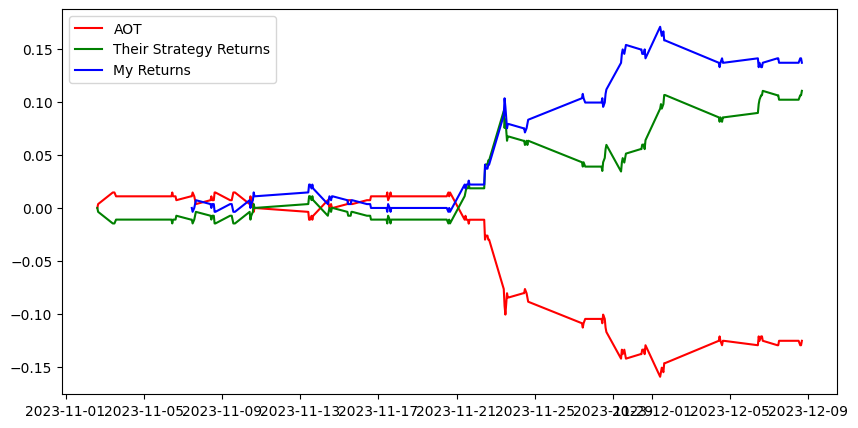

In [16]:
#the original method's graph
df['Predicted_Signal'] = model.predict(X)
df['AOT_movement'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_AOT_returns = np.cumsum(df[split:]['AOT_movement'])
df['Original_Startegy_returns'] = df['AOT_movement']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Original_Startegy_returns'])

#my model's graph
df2.loc[:, 'Predicted_Signal2'] = model2.predict(X2)
df2.loc[:, 'AOT_movement'] = np.log(df2['Close'] / df2['Close'].shift(1))
df2.loc[:, 'My_returns'] = df2['AOT_movement'] * df2['Predicted_Signal2'].shift(1)
Cumulative_My_returns = np.cumsum(df2[split:]['My_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_AOT_returns, color='r',label = 'AOT')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Their Strategy Returns')
plt.plot(Cumulative_My_returns, color='b', label = 'My Returns')
plt.legend()
plt.show()